In [3]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from time import time
import math

In [4]:
# Initializing mediapipe pose class
mp_pose = mp.solutions.pose

# Setting up the pose function
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation
mp_drawing = mp.solutions.drawing_utils

In [5]:
def detectPose(image, pose, display=True):
    
    # create a copy of the input image
    output_image = image.copy()
    
    # convert the image from BGR into RGB format
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the activity detection
    result = pose.process(imageRGB)
    
    # Retrieve the height and width of the input image.
    height, width, _ = image.shape
    
    # Initialize a list to store the detected landmark.
    landmarks = []
    
    # Check if any landmarks are detected
    if result.pose_landmarks:
        
        # Draw pose landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_image, landmark_list = result.pose_landmarks,
                                 connections = mp_pose.POSE_CONNECTIONS)
        
        # Iterate over the detected landmarks.
        for landmark in result.pose_landmarks.landmark:
            
            # Append the landmark into the list.
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                            (landmark.z * width)))
            
    if display:
        
        # Display the original input image and the resultant image
        plt.figure(figsize=[22,22])
        plt.subplot(121)
        plt.imshow(image[:,:,::-1])
        plt.title("Original image")
        plt.axis('off')
        plt.subplot(122)
        plt.imshow(output_image[:,:,::-1])
        plt.title("Output image")
        plt.axis('off')
        
        # Also Plot the Pose landmarks in 3D.
        mp_drawing.plot_landmarks(result.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        
    else:
        return output_image, landmarks

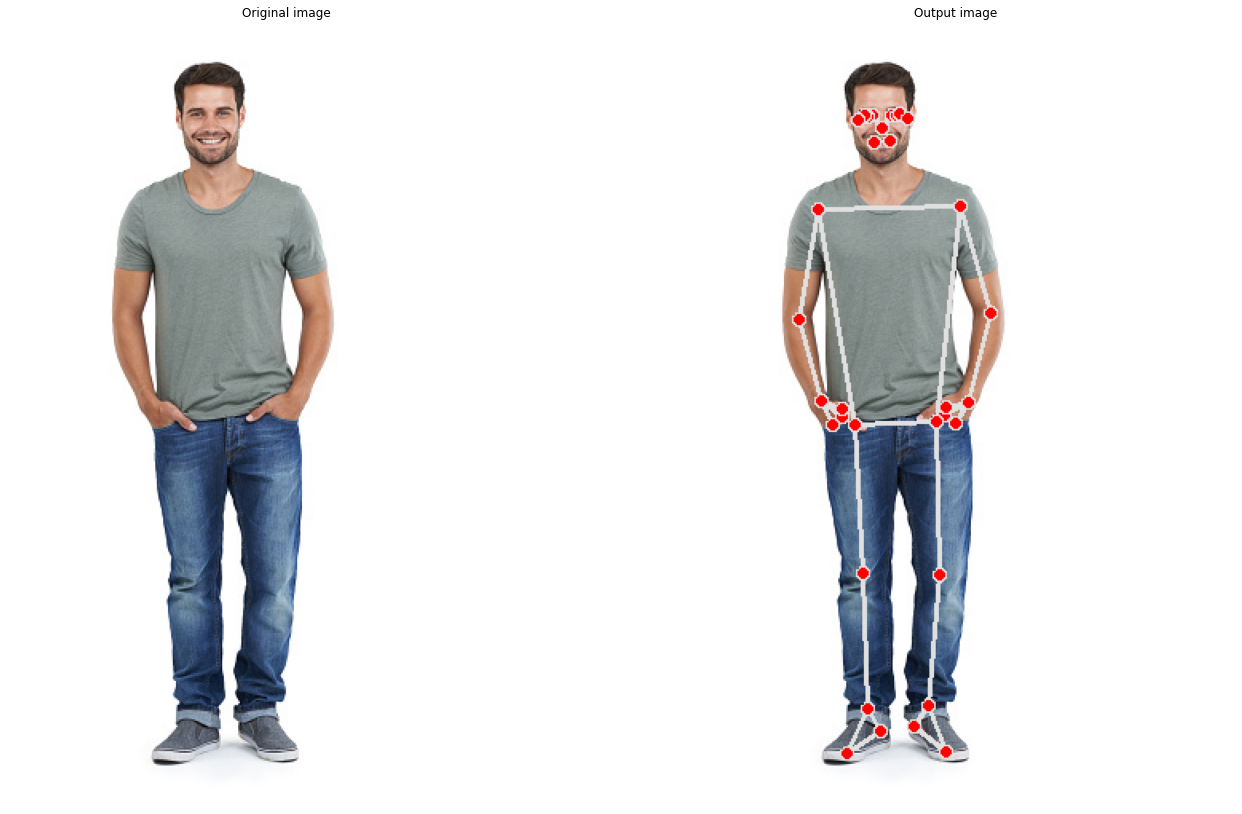

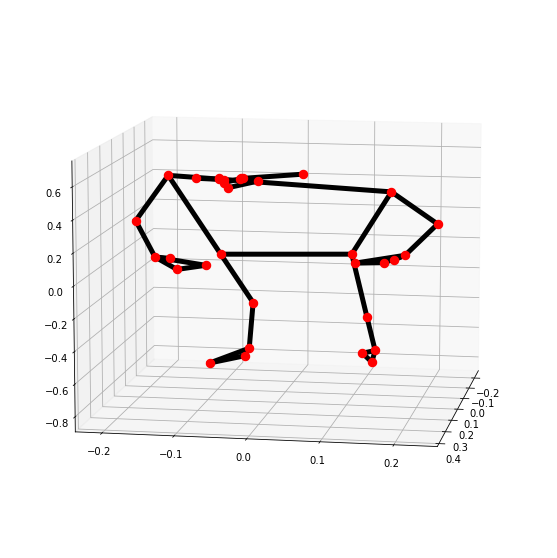

In [6]:
# Read another sample image and perform pose detection on it
image = cv2.imread(r"C:\Users\prash\Desktop\data\HUMAN POSE DETECTION\standing.jpg")
detectPose(image, pose, display=True)

# Pose Detection On Real-Time Webcam Video

In [7]:
# Setup Pose function for video
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5,
                         model_complexity=1)

# Initialize the VideoCapture object to read from the webcam
video = cv2.VideoCapture(0)

# Create named window for resizing purposes
cv2.namedWindow('Pose Detection', cv2.WINDOW_NORMAL)

# Set video camera size
video.set(3,1280)
video.set(4,960)

# Initialize a variable to store the time of the previous frame.
time1 = 0

# Iterate until the video is accessed successfully
while video.isOpened():
    
    # Read a frame
    ret, frame = video.read()
    
    # Check if frame is not read properly
    if not ret:
        break
     
    # Flip the frame horizontally for natural visualization
    frame = cv2.flip(frame, 1)
    
    # Get the width and height of the frame
    frame_height, frame_width, _ = frame.shape
    
    # Resize the frame while keeping the aspect ratio
    frame = cv2.resize(frame, (int(frame_width*(640/frame_height)),640))
    
    # Perform pose landmark detection
    frame, _ = detectPose(frame, pose_video, display=False)
    
    time2 = time()
    
    if (time2 - time1) > 0:
        frame_per_second = 1.0/(time2-time1)
        
        cv2.putText(frame, 'FPS: {}'.format(int(frame_per_second)),(10,30),
                   cv2.FONT_HERSHEY_PLAIN, 2, (0,255,0),3)
        
    # Update the previous frame time to this frame time.
    # As this frame will become previous frame in next iteration
    time1 = time2
    
    # Display the frame
    cv2.imshow("Pose Detection", frame)
    
    # wait until a key is pressed
    # Retreive the ASCII code of the key pressed
    k = cv2.waitKey(1) & 0xFF
    
    # check if 'ESC' is pressed
    if(k==27):
        break
        
video.release()
cv2.destroyAllWindows()

# Pose Classification with Angle

In [8]:
def calculateAngle(landmark1, landmark2, landmark3):
    
    # Get the required landmarks coordinates
    x1, y1,_ = landmark1
    x2, y2,_ = landmark2
    x3, y3,_ = landmark3
    
    # Claculate the angle between the three points
    angle = math.degrees(math.atan2(y3 - y2, x3-x2)-math.atan2(y1-y2, x1-x2))
    
    # Check if the angle is less than zero
    if angle<0:
        
        # Add 360 to the found angle.
        angle+=360
        
    # return the calculated angle.
    return angle

In [9]:
def classifyPose(landmarks, output_image, display=True):
    
    # Initialize the label of the pose. It is not known at this stage.
    label = 'Unknown Pose'
    
    # Specify the color with which the label will be written on the image
    color = (0,0,255)
    
    # Calculate the required angles
    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                     landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                     landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])
    
    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])
    
    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                     landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])
    
    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])
    
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
    
    if left_elbow_angle > 165 and left_elbow_angle < 195 and right_elbow_angle > 165 and right_elbow_angle < 195:
        
        if left_shoulder_angle > 80 and left_shoulder_angle < 110 and right_shoulder_angle > 80 and right_shoulder_angle <110:
            
            if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:
                
                if left_knee_angle > 90 and left_knee_angle < 120 or right_knee_angle > 90 and right_knee_angle < 120:
                    
                    label = 'Warrior II Pose'
                    
            if left_knee_angle > 160 and left_knee_angle < 195 and right_knee_angle > 160 and right_knee_angle < 195:
                label = 'T Pose'
                
    if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:
        if left_knee_angle > 315 and left_knee_angle < 335 or right_knee_angle > 25 and right_knee_angle < 45:
            label = 'Tree Pose'
            
    if label !='Unknown Pose':
        color = (0,255,0)
    cv2.putText(output_image, label, (10,30),cv2.FONT_HERSHEY_PLAIN, 2, color,2)

    if display:
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1])
        plt.title("Output Image")
        plt.axis('off')

    else:
        return output_image, label

In [10]:
# Set Pose function for video
pose_video = mp_pose.Pose(static_image_mode = False, min_detection_confidence=0.5, model_complexity=1)

# Initialize the VideoCapture object to read from the webcam
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

cv2.namedWindow('Pose Classification', cv2.WINDOW_NORMAL)

while camera_video.isOpened():
    ret, frame = camera_video.read()
    
    if not ret:
        continue
        
    frame = cv2.flip(frame,1)
    
    frame_height, frame_width, _ = frame.shape
    
    frame = cv2.resize(frame, (int(frame_width * (640/frame_height)),640))
    
    frame, landmarks = detectPose(frame, pose_video, display=False)
    
    if landmarks:
        
        frame, _ = classifyPose(landmarks, frame, display=False)
        
    cv2.imshow('Pose Classification', frame)
    
    k = cv2.waitKey(1) & 0xFF
    
    if(k==27):
        break
        
video.release()
cv2.destroyAllWindows()